In [37]:
import numpy as np
import os
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import curve_fit

plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
plt.rc('figure', titlesize=20)

In [38]:
sim_time = 16 * 2*np.pi
steps = 160
tlist = np.linspace(0, sim_time, steps+1)
tlist_long = np.linspace(0, sim_time, steps*10+1)

motion_T2 = 5.18e-3
total_kick_time = 0.584224e-3
Gamma = 2/motion_T2 * total_kick_time / sim_time
print('Gamma: ', Gamma)

Gamma:  0.0022437774486708368


In [39]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, ion3, ion3_raw, ion3_bottom, ion3_top, ion4, ion4_raw, ion4_bottom, \
    ion4_top, ion5, ion5_raw, ion5_bottom, ion5_top, ion2, ion2_raw, ion2_bottom, ion2_top, ion6, ion6_raw, \
    ion6_bottom, ion6_top\
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None,
                   skiprows=0,unpack=True, encoding='latin1')
    return x, ion4

def get_pops_from_fileno(no, steps):
    _, pop = readFile('Heating_%s'%str(no).zfill(3))
    return np.array(pop[:steps])

def get_pops_list_from_fileno(no_list, steps):
    pop_list = []
    for no in no_list:
        pop = get_pops_from_fileno(no, steps)
        pop_list += [pop]
    return np.array(pop_list).reshape((len(no_list), -1))

In [40]:
def get_pops(params, option='c'):
    
    Nmax = params['Nmax']
    H = params['eps']/2 * tensor(sigmaz(), qeye(Nmax))
    H += params['Delta']/2 * tensor(sigmax(), qeye(Nmax))
    H += params['kappa']/2 * tensor(sigmaz(), (destroy(Nmax) + create(Nmax)))  
    H += params['nu'] * tensor(qeye(2), create(Nmax) * destroy(Nmax))
    
    init_state = tensor(ket2dm(basis(2,0)), thermal_dm(Nmax, params['nbar']))
    tlist = params['tlist']
    e_op = tensor(ket2dm(basis(2,0)), qeye(Nmax))
    e_op2 = tensor(qeye(2), create(Nmax) * destroy(Nmax))
    
    if option == 'c':
        c_ops = [np.sqrt(params['Gamma'] * (params['nbar'] + 1)) * tensor(qeye(2), destroy(Nmax))]
        if params['nbar'] > 0:
            c_ops += [np.sqrt(params['Gamma'] * params['nbar']) * tensor(qeye(2), create(Nmax))]
    elif option == 'd':
        c_ops = [np.sqrt(params['Gamma']) * tensor(qeye(2), create(Nmax) * destroy(Nmax))]
        
    result = mesolve(H, init_state, tlist, e_ops=[e_op, e_op2], c_ops=c_ops)
    pops = result.expect[0]
    phonons = result.expect[1]
    
    return pops, phonons

def sim_fn(t, nbar):
    params = {'nu': 1., 'eps': 0., 'Delta': 1., 'kappa': .1, 'Gamma': 0., 'nbar': nbar,
              'tlist': t, 'Nmax': 10}
    pops, _ = get_pops(params)
    return pops

def fit_fn(t, nbar): 
    params = {'nu': 1., 'eps': 0., 'Delta': 1., 'kappa': .1, 'Gamma': Gamma, 'nbar': nbar,
              'tlist': t, 'Nmax': 10}
    pops, _ = get_pops(params)
    return pops

In [41]:
nbar_list = [0., 0.25, 0.5, 1., 2.]
fileno_lists = [[0]]
fileno_lists += [np.arange(1, 21).tolist()]
fileno_lists += [np.arange(21, 41).tolist()]
fileno_lists += [np.arange(41, 66).tolist()]
fileno_lists += [np.arange(66, 91).tolist()]

In [43]:
simdata_list = []
expdata_list = []
errorbar_list = []
fitdata_list = []

fitted_nbar_list = []
fitted_nbar_std_list = []

##################################################

nbar = nbar_list[0]
fileno_list = fileno_lists[0]

simdata_list += [sim_fn(tlist_long, nbar)]
expdata_all = get_pops_list_from_fileno(fileno_list, steps)
expdata = np.mean(expdata_all, axis=0)
expdata_list += [expdata]
errorbar = np.maximum(np.sqrt(expdata * (1-expdata) / 100 / len(fileno_list)), 1e-3)
errorbar_list += [errorbar]

popt, pcov = curve_fit(fit_fn, tlist[:-1], expdata, p0=[nbar], sigma=errorbar, absolute_sigma=True,\
                       bounds = (0., np.inf))
fitted_nbar_list += [popt[0]]
fitted_nbar_std_list += [np.sqrt(np.diag(pcov))[0]]
fitdata_list += [fit_fn(tlist_long, popt[0])]

print('target nbar: ', nbar)
print('fitted nbar: ', popt)
print('fitted std: ', np.sqrt(np.diag(pcov)))
print('')

for i in range(1, len(nbar_list)):
    nbar = nbar_list[i]
    fileno_list = fileno_lists[i]
    
    simdata_list += [sim_fn(tlist_long, nbar)]
    expdata_all = get_pops_list_from_fileno(fileno_list[:20], steps)
    expdata = np.mean(expdata_all, axis=0)
    expdata_list += [expdata]
    
    variance = np.std(expdata_all, axis=0)**2 / len(fileno_list[:20])
    shotnoise = np.maximum(np.sqrt(expdata_all * (1-expdata_all) / 100), 1e-3)
    variance = variance + np.mean(shotnoise**2, axis=0)
    errorbar = np.sqrt(variance)
    errorbar_list += [errorbar]
    
    popt, pcov = curve_fit(fit_fn, tlist[:-1], expdata, p0=[nbar], sigma=errorbar, absolute_sigma=True)
    fitted_nbar_list += [popt[0]]
    fitted_nbar_std_list += [np.sqrt(np.diag(pcov))[0]]
    fitdata_list += [fit_fn(tlist_long, popt[0])]
    
    print('target nbar: ', nbar)
    print('fitted nbar, nu: ', popt)
    print('fitted std: ', np.sqrt(np.diag(pcov)))
    print('')

target nbar:  0.0
fitted nbar:  [2.e-10]
fitted std:  [0.00895671]

target nbar:  0.25
fitted nbar, nu:  [0.39797676]
fitted std:  [0.00196932]

target nbar:  0.5
fitted nbar, nu:  [0.61384885]
fitted std:  [0.04127502]

target nbar:  1.0
fitted nbar, nu:  [0.99999994]
fitted std:  [0.00059721]

target nbar:  2.0
fitted nbar, nu:  [2.]
fitted std:  [0.03302617]



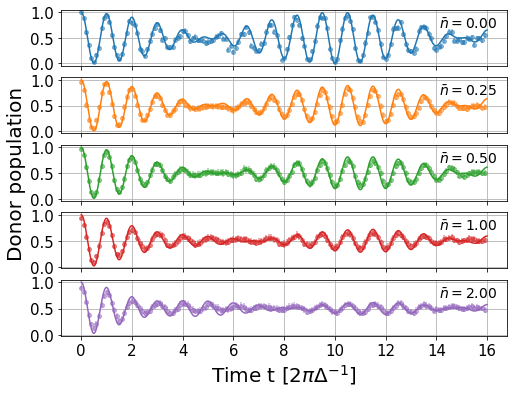

In [44]:
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

fig, axs = plt.subplots(5, 1, figsize=(8,6), gridspec_kw={'hspace': 0.2})
for i in range(len(expdata_list)):
    axs[i].plot(tlist_long/2/np.pi, simdata_list[i], '-', color=color_list[i], label=r'$\bar{n}=%.2f$'%nbar_list[i])
    axs[i].errorbar(tlist[:-1]/2/np.pi, expdata_list[i], yerr=errorbar_list[i], fmt='o', alpha=0.5,\
                    markersize=4,color=color_list[i], ecolor=color_list[i], mfc=color_list[i])
#     axs[i].plot(tlist_long/2/np.pi, fitdata_list[i], '--', color='k', alpha=0.8, label='fit')
#     axs[i].set_title(r'$\bar{n}=%.2f$'%nbar_list[i]);
#     axs[i].label_outer()
    axs[i].grid()
    axs[i].set_yticks([0.0, 0.5, 1.0])
    axs[i].text(14.1, 0.7, r'$\bar{n}=%.2f$'%(nbar_list[i]), fontsize=14)
    axs[i].label_outer()
    
# plt.tight_layout()
axs[4].set_xlabel(r'Time t [$2\pi\Delta^{-1}]$')
axs[2].set_ylabel('Donor population');
plt.savefig('Figure2_11.png', dpi=300, bbox_inches='tight')

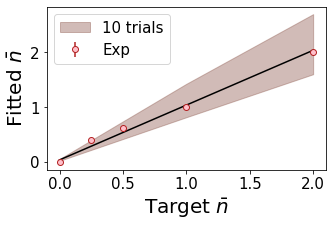

In [45]:
nbar_list = np.array(nbar_list)
nbar_mean_list = np.array([0., 0.27112907, 0.54225482, 1.08383568, 2.11181982])
nbar_std_list = np.array([0., 0.07239123, 0.14478033, 0.28900112, 0.532043])
nbar_meas = 0.036
nbar_meas_std = 0.016

fig, ax = plt.subplots(1, figsize=(5, 3))
ax.plot(nbar_list, nbar_list + nbar_meas, '-', color='k')
ax.errorbar(nbar_list, fitted_nbar_list, yerr=fitted_nbar_std_list,\
            ls = '', marker='o', mec='firebrick', ecolor='firebrick' ,mfc='pink', label='Exp')

ax.fill_between(nbar_list,
                nbar_mean_list - nbar_std_list + nbar_meas - nbar_meas_std,
                nbar_mean_list + nbar_std_list + nbar_meas + nbar_meas_std,
                color='tab:brown', alpha=0.4, label='10 trials')

ax.set_xlabel('Target ' + r'$\bar{n}$')
ax.set_ylabel('Fitted ' + r'$\bar{n}$')
# ax.set_xticks(nbar_list)
# ax.set_yticks(nbar_list)
ax.legend();
plt.savefig('Figure2_12.png', dpi=300, bbox_inches='tight')

In [46]:
nbar_list = np.array(nbar_list)
nbar_20trials_mean_list = np.array([0., 0.25387975, 0.50775705, 1.01509032, 1.99466128])
nbar_20trials_std_list = np.array([0., 0.048823, 0.09764478, 0.19499227, 0.36839169])
nbar_200trials_mean_list = np.array([0., 0.25387975, 0.50775705, 1.01509032, 1.99466128])
nbar_200trials_std_list = np.array([0., 0.00920853, 0.01841687, 0.03678655, 0.07045805])
nbar_meas = 0.036
nbar_meas_std = 0.016

fig, ax = plt.subplots(1, figsize=(5,3))
ax.plot(nbar_list, nbar_list + nbar_meas, '-', color='k')
ax.errorbar(nbar_list, fitted_nbar_list, yerr=fitted_nbar_std_list,\
            ls = '', marker='o', mec='firebrick', ecolor='firebrick' ,mfc='pink', label='Exp')

ax.fill_between(nbar_list,
                nbar_20trials_mean_list - nbar_20trials_std_list + nbar_meas - nbar_meas_std,
                nbar_20trials_mean_list + nbar_20trials_std_list + nbar_meas + nbar_meas_std,
                color='tab:brown', alpha=0.4, label='20 trials')

ax.fill_between(nbar_list,
                nbar_200trials_mean_list - nbar_200trials_std_list + nbar_meas - nbar_meas_std,
                nbar_200trials_mean_list + nbar_200trials_std_list + nbar_meas + nbar_meas_std,
                color='tab:blue', alpha=0.4, label='200 trials')

ax.set_xlabel('Target ' + r'$\bar{n}$')
ax.set_ylabel('Fitted ' + r'$\bar{n}$')
# ax.set_xticks(nbar_list)
# ax.set_yticks(nbar_list)
ax.legend();
plt.savefig('Figure2_12.png', dpi=300, bbox_inches='tight')

nbar: 0.00
sim - fitting coeffs:  [ 0.48913896  0.99979987 -1.55752994]
sim - std of fitting coeffs:  [0.00295078 0.0016371  0.10814397]
exp - fitting coeffs:  [ 0.47064107  1.0070773  -1.98011924]
exp - std of fitting coeffs:  [0.008753   0.00905012 0.59675542]
sim2 - fitting coeffs:  [ 0.4526178   0.99985243 -1.56388815]
sim2 - std of fitting coeffs:  [0.00208316 0.00124899 0.08250502]

nbar: 0.25
sim - fitting coeffs:  [ 0.3848822   0.99933529 -1.53422274]
sim - std of fitting coeffs:  [0.00143862 0.00101447 0.06701238]
exp - fitting coeffs:  [-0.32441419  0.99327536  1.77786561]
exp - std of fitting coeffs:  [0.01673105 0.01668625 1.10140645]
sim2 - fitting coeffs:  [ 0.34712102  0.99940426 -1.54112467]
sim2 - std of fitting coeffs:  [0.00128614 0.0010056  0.06642604]

nbar: 0.50
sim - fitting coeffs:  [ 0.31000854  0.99913678 -1.52549407]
sim - std of fitting coeffs:  [0.00246181 0.00215543 0.14237721]
exp - fitting coeffs:  [0.24301885 0.9952814  4.85366349]
exp - std of fitting 

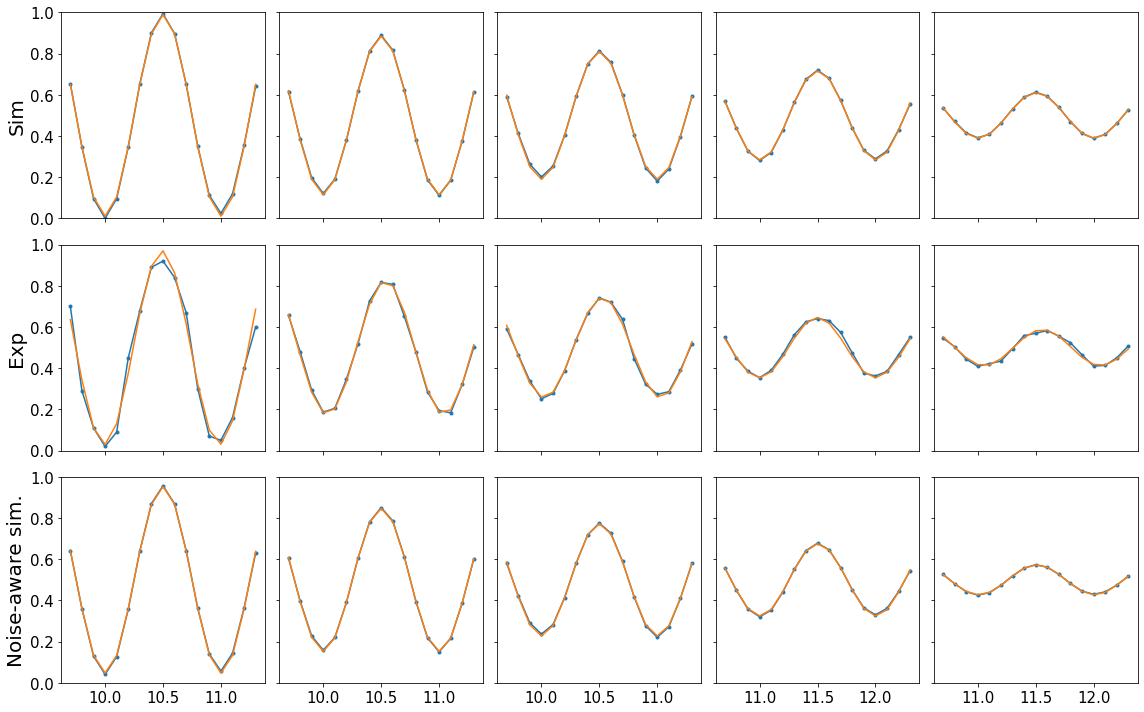

In [40]:
# takes dephasing and imperfect cooling into account
def noise_aware_sim(t, nbar): 
    params = {'nu': 1., 'eps': 0., 'Delta': 1., 'kappa': .1, 'Gamma': Gamma, 'nbar': nbar+nbar_meas,
              'tlist': t, 'Nmax': 10}
    pops, _ = get_pops(params)
    return pops

def sin(t, A, f, phi):
    return A * np.sin(2*np.pi*f * t + phi) + 0.5

sim_contrast_list = []
exp_contrast_list = []
exp_contrast_std_list = []
sim_contrast_list2 = []  # noise aware!

fig, axs = plt.subplots(3, 5, figsize=(16, 10))

for i in range(len(nbar_list)):
    nbar = nbar_list[i]
    print('nbar: %.2f'%nbar)
    
    simdata = sim_fn(tlist, nbar)
    expdata = expdata_list[i]
    errorbar = errorbar_list[i]
    simdata2 = noise_aware_sim(tlist, nbar)
    
    max_ind = np.argmax(simdata[90:140]) + 90
    start = max_ind - 8
    end = max_ind + 9
    
    popt, pcov = curve_fit(sin, tlist[start:end]/2/np.pi, simdata[start:end], p0=[1, 1, 0])
    pstd = np.sqrt(np.diag(pcov))
    print('sim - fitting coeffs: ', popt)
    print('sim - std of fitting coeffs: ', pstd)
    sim_contrast_list += [np.abs(popt[0])] 
    axs[0][i].plot(tlist[start:end]/2/np.pi, simdata[start:end], '.-')
    axs[0][i].plot(tlist[start:end]/2/np.pi, sin(tlist[start:end]/2/np.pi, *popt))
    axs[0][i].set_ylim((0,1))
    axs[0][i].label_outer()

    popt, pcov = curve_fit(sin, tlist[start:end]/2/np.pi, expdata[start:end], \
                           p0=[1, 1, 0], sigma=errorbar[start:end], absolute_sigma=True)
    pstd = np.sqrt(np.diag(pcov))
    print('exp - fitting coeffs: ', popt)
    print('exp - std of fitting coeffs: ', pstd)
    exp_contrast_list += [np.abs(popt[0])]
    exp_contrast_std_list += [pstd[0]]
    axs[1][i].plot(tlist[start:end]/2/np.pi, expdata[start:end], '.-')
    axs[1][i].plot(tlist[start:end]/2/np.pi, sin(tlist[start:end]/2/np.pi, *popt))
    axs[1][i].set_ylim((0,1))
    axs[1][i].label_outer()
    
    popt, pcov = curve_fit(sin, tlist[start:end]/2/np.pi, simdata2[start:end], p0=[1, 1, 0])
    pstd = np.sqrt(np.diag(pcov))
    print('sim2 - fitting coeffs: ', popt)
    print('sim2 - std of fitting coeffs: ', pstd)
    print('')
    sim_contrast_list2 += [np.abs(popt[0])]   
    axs[2][i].plot(tlist[start:end]/2/np.pi, simdata2[start:end], '.-')
    axs[2][i].plot(tlist[start:end]/2/np.pi, sin(tlist[start:end]/2/np.pi, *popt))
    axs[2][i].set_ylim((0,1))
    axs[2][i].label_outer()

axs[0][0].set_ylabel('Sim')
axs[1][0].set_ylabel('Exp')
axs[2][0].set_ylabel('Noise-aware sim.')
plt.tight_layout()               

In [41]:
fig, ax = plt.subplots(1, figsize=(5,3))
ax.plot(nbar_list, sim_contrast_list, '-', label='sim', color='k')
ax.plot(nbar_list, sim_contrast_list2, '--', label='noise aware sim', color='k')
ax.errorbar(nbar_list, exp_contrast_list, yerr=exp_contrast_std_list,\
            ls = '', marker='o',mec='firebrick', ecolor='firebrick',mfc='pink')

ax.set_xlabel(r'$\bar{n}$')
ax.set_ylabel('Revival amp.')
ax.legend();
plt.savefig('Figure2_13.png', dpi=300, bbox_inches='tight')